In [48]:
# General Imports
import os
import numpy as np
import matplotlib.pyplot as plt
from typing import Dict, Iterable, Any

# Tensorflow Imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam

# Scikit Keras wrapper
from scikeras.wrappers import KerasRegressor

# Specialised loading bar for trainiung
from keras_tqdm import TQDMNotebookCallback

# Custom imports
from pendulum import Pendulum_2D

In [70]:
class HNN(keras.Sequential):
    '''
    Framework for the Equation-driven Hamiltonian Neural Network. 
    '''
    
    def __init__(self, t0 = None, 
                       tfinal = None, 
                       N = None,
                       initial_state = None, 
                       environment_parameters = None, 
                       name = None, 
                       hamilton_equations = None, 
                       parametric_equation = None, 
                       hamiltonian = None, 
                       regularization = False): 
        
        super(HNN, self).__init__(name=name)
        
        # Functions 
        self.hamilton_equations = hamilton_equations
        self.parametric_equation = parametric_equation
        self.hamiltonian = hamiltonian
        
        # Time parameters
        self.t0 = tf.Variable(t0, dtype = tf.float32) 
        self.tfinal = tf.Variable(tfinal, dtype = tf.float32) 
        self.N = tf.Variable(N, tf.float32) 
        self.grid = tf.reshape(tf.linspace(self.t0, self.tfinal, self.N), (-1, 1)) # Base time grid
        self.dt = tf.cast((self.grid[1] - self.grid[0])[0], tf.float32)

        # Initial state
        self.initial_state = tf.convert_to_tensor(initial_state, dtype = tf.float32)
        
        if regularization: 
            self.H0 = self.hamiltonian(self.initial_state) 
        
        # Environment parameters
        self.environment_parameters = environment_parameters
    
    @tf.function
    def train_step(self, data):
        '''
        
        '''
        # Unpack the data. 
        _, __ = data 
        
        # tf.print("Time before = ", self.grid)
        time = self.getTimes() 
        # tf.print("Time after = ", time) 
        
        # Watch gradients for backpropagation
        with tf.GradientTape() as tape:
            
            # Watch gradients for calculating time derivative of output for loss
            with tf.GradientTape() as tape2: 
                tape2.watch(time) 
                nn_result = self(time, training=True)  # Forward pass
                state_pred = self.parametric_equation(time, nn_result, self.initial_state) # Enforce initial condition
            
            # Create LHS and RHS of Hamilton equations
            state_deriv_from_hamilton = self.hamilton_equations(state_pred, self.environment_parameters)

            # Get all partial derivatives with jacobian (AD) 
            state_deriv_from_ad = tape2.jacobian(state_pred, time) 
            
            # Reshape the jacobian monstrosity.... Line 1 might be wrong, is 2 hardcoded?
            idx = tf.reshape(tf.stack(tf.meshgrid(tf.range(state_pred.shape[0]), tf.range(state_pred.shape[1]), indexing='ij'), axis=-1), [-1, 2])
            idx = tf.expand_dims(tf.concat([idx, tf.expand_dims(idx[:, 0], axis=-1)], axis=-1), axis=1)
            state_deriv_from_ad = tf.gather_nd(state_deriv_from_ad, idx)
            state_deriv_from_ad = tf.reshape(state_deriv_from_ad, state_pred.shape)
            
            # tf.print("Time           = ", time)
            # tf.print("RHS (hamilton) = ", state_deriv_from_hamilton)
            # tf.print("LHS (AD)       = ", state_deriv_from_ad)
            # tf.print("")
            
            # Debugging
            # tf.print("state_pred shape: ", state_pred.shape)
            # tf.print("state_deriv_from_hamilton shape: ", state_deriv_from_hamilton.shape)
            # tf.print("state_deriv_from_ad shape: ", state_deriv_from_ad.shape) 
            
            # Compute the loss value
            loss = self.compiled_loss(state_deriv_from_ad, state_deriv_from_hamilton)
            
            if 
            
            # tf.print("loss = ", loss) 
            
        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        self.compiled_metrics.update_state(state_deriv_from_ad, state_deriv_from_hamilton)
        
        return {m.name: m.result() for m in self.metrics}
    
    
#     def hamilton_equations(self, 
#                            tens, 
#                            params): 
        
#         q_tens = tens[:,:1]
#         p_tens = tens[:,1:]
        
#         q_deriv = tf.multiply(p_tens, 1./(params['m'] * params['l'] * params['l']))
#         p_deriv = tf.multiply(tf.math.sin(q_tens), -9.81 * params['m'] * params['l']) 
        
#         deriv = tf.concat([q_deriv, p_deriv], axis = 1)        
#         return deriv
    
#     def parametric_equation(self, 
#                             times, 
#                             states, 
#                             initial_state): 
        
#         f = 1 - tf.math.exp(-times)
#         result = initial_state + f * states
        
#         return result
    
    def parametric_predict(self, x): 
        '''
        custom predict that predicts and aplies the parametric equation 
        '''
        
        x = tf.convert_to_tensor(x, dtype = tf.float32) 
        return self.parametric_equation(x, self.predict(x), self.initial_state).numpy()
    
    def getTimes(self): 
        '''
        Create time training data by perturbing the baseline time grid.
        '''
        # Create noise
        noise = tf.random.normal(self.grid.shape, mean = 0, stddev = tf.multiply(self.dt, 0.3))
        
        new_times = self.grid + noise 

        # Make sure time is not outside [t0, tf]: set to t0 or tf if violated
        new_times = tf.where(tf.less(new_times, self.t0), self.t0, new_times)
        new_times = tf.where(tf.greater(new_times, self.tfinal), self.tfinal, new_times)

        return new_times
    
    def get_config(self):
        
        config = super().get_config()
        
        # Add the additional arguments to the serialized configuration
        config.update({
             't0': self.t0,
             'tfinal': self.tfinal,
             'N': self.N,
             'initial_state': self.initial_state,
             'environment_parameters': self.environment_parameters
        })
        
        return config
    
    
class SineActivationLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(SineActivationLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        super(SineActivationLayer, self).build(input_shape)

    def call(self, inputs):
        return tf.math.sin(inputs)
    
    def get_config(self): 
        return super().get_config()

    def compute_output_shape(self, input_shape):
        return input_shape
    
    
def custom_mse(y_true, y_pred):  
        
    difference = y_true - y_pred 
    difference_squared = difference**2
    loss = tf.math.reduce_mean(tf.math.reduce_sum(difference_squared, axis = 1))
    
    return loss

In [71]:
# System parameters
m = 1
l = 1

# Initial condition
y0 = np.array([np.pi/4, 0]) 
t0 = 0

# Integration
tfinal = 4
N = 200

# Create benchmark 
bench = Pendulum_2D(m, l)
bench.set_initial_condition(t0, y0, "generalized")
bench.integrate("dop853", tfinal, "generalized", rtol = 1e-12, atol = 1e-12)
bench.calculate_coordinates("canonical")
print(bench.time) 

0.012998580932617188


## Trying to create a loading function

In [ ]:
# This is supposed to be temporary
def load_model(path): 
    
    model = build_hnn((50, 50), 
                      None,
                      [t0, tfinal, N],
                      y0, 
                      {"m": m, "l": l},
                      weights_path = path)
    
    regr = KerasRegressor(model)
    
# Hypothetical...
def load_model_2(path): 
    model = keras.models.load_model("my_model", custom_objects={"HNN": HNN, "SineActivationLayer": SineActivationLayer})
    return model

def load_model_3(arc_path, weights_path): 
    
    pass

model = load_model("hnn_models/pendulum/model4.tf")

## Building and fitting the model via Scikeras

In [23]:
def build_hnn_scikeras(hidden_layer_sizes: Iterable[int], 
              compile_kwargs: Dict[str, Any],
              time_parameters, 
              initial_state,
              environment_parameters, 
              weights_path = None):
    
    # Create an HNN
    model = HNN(time_parameters, 
                initial_state, 
                environment_parameters)
    
    # Define input layer, always 1 dimension: time
    inp = keras.layers.Input(shape=(1,))
    model.add(inp)
    
    # Define hidden layer structure
    for hidden_layer_size in hidden_layer_sizes:
        layer = keras.layers.Dense(hidden_layer_size, activation=SineActivationLayer())
        model.add(layer)
    
    # Final layer
    out = keras.layers.Dense(2)
    model.add(out)
    
    if weights_path != None: 
        print("loading weights")
        model.load_weights(weights_path)

    print("Hello, world!")
    print(compile_kwargs["optimizer"]) 

    model.compile(loss=loss, optimizer=compile_kwargs["optimizer"])

    return model

regr = KerasRegressor(model=build_hnn_scikeras, 
                            hidden_layer_sizes=(50, 50),
                            optimizer= "adam",
                            epochs = int(5e4),
                            loss=custom_mse,
                            batch_size = N,
                            run_eagerly =  False,
                            optimizer__beta_1 = 0.999, 
                            optimizer__beta_2 = 0.999, 
                            optimizer__learning_rate=8e-3, 
                            time_parameters = [t0, tfinal, N],
                            initial_state = y0, 
                            environment_parameters = {"m": m, "l": l})

regr.fit(np.zeros(N).reshape(-1, 1), 
         np.zeros((N, 2)), 
         verbose = 0)

## Building a general HNN model directly from keras

In [72]:
def _check_arguments(args): 
    '''
    Check if all the required arguments are passed
    '''
    
    for arg, value in args.items(): 
        if value is None: 
            raise ValueError(f"Argument '{arg}' not provided, idiot!") 

def _build_optimizer(optimizer, optimizer_config):
    '''
    Create optimizer with provided parameters
    '''
    # Choose optimizer
    if optimizer == "adam":
        optimizer_object = tf.keras.optimizers.Adam(learning_rate=optimizer_config['lr'], 
                                 beta_1=optimizer_config['beta_1'], 
                                 beta_2=optimizer_config['beta_2'])
    else: 
        raise ValueErrror("Optimizer not implemented")
    
    return optimizer_object
        
def build_hnn_keras(hidden_layer_sizes = None,
                  optimizer = None,
                  optimizer_config = None,
                  loss_function = None,
                  time_parameters = None, 
                  initial_state = None,
                  environment_parameters = None, 
                  hamilton_equations = None, 
                  parametric_equation = None, 
                  hamiltonian = None, 
                  regularization = False):
    '''
    Function that build an HNN(keras.sequential) model
    
    Args: 
        hidden_layer_size (iterable) :   The amount of neurons in the each hidden layer
        optimizer         (string)   :   The optimisation algorithm. 
        optimizer_config  (dict)     :   The hyperparameters for the training algorithm
        loss_function     (function) :   The loss function taking 2 arguments: ypred and ytrue
        time_parameters   (list)     :   Array with [t0, tfinal, N] where N is the amount of training
                                         times per epoch
        initial_state     (np.array) :   The initial state
        environment parameters (dict):   The paramters of the envirenment, mass and length for a 
                                         pendulum
        hamilton_equations (function):   The hamilton equations, in terms of tf.Tensor
        
    Returns: 
        model             (HNN)     :  An equation based Hamiltonian Neural network 
    '''
    # Check if all the required arguments are provided 
    _check_arguments(locals()) 
        
    # Create an equation based HNN
    model = HNN(t0 = time_parameters[0], 
                tfinal = time_parameters[1],
                N = time_parameters[2],
                initial_state = initial_state, 
                environment_parameters = environment_parameters, 
                hamilton_equations = hamilton_equations, 
                parametric_equation = parametric_equation, 
                hamiltonian = hamiltonian,
                regularization = regularization)
    
    # Define input layer, always 1 dimension: time
    inp = keras.layers.Input(shape=(1,))
    model.add(inp)
    
    # Define hidden layer structure
    for hidden_layer_size in hidden_layer_sizes:
        layer = keras.layers.Dense(hidden_layer_size, activation=SineActivationLayer())
        model.add(layer)
    
    # Final layer
    out = keras.layers.Dense(2)
    model.add(out)

    # Compile model with optimizer and loss
    model.compile(loss=loss_function, 
                  optimizer=_build_optimizer(optimizer, optimizer_config))

    return model



## Specific scenario, defined by the choice of Hamilton equations and parametric equations
### Create the model, with loss and optimizer
### Fit the model

In [73]:
def pe1(times,
        states,
        initial_state): 
    '''
    Parametric equation enforcing the initial condition on the Neural network
    '''
    
    # Perform Parametric equation
    f = 1 - tf.math.exp(-times)
    result = initial_state + f * states
    
    return result
    
def pendulum_hamilton(tens, params): 
    '''
    Hamiton equations for a 2D pendulum
    '''
    
    q_tens = tens[:,:1]
    p_tens = tens[:,1:]

    q_deriv = tf.multiply(p_tens, 1./(params['m'] * params['l'] * params['l']))
    p_deriv = tf.multiply(tf.math.sin(q_tens), -9.81 * params['m'] * params['l']) 

    deriv = tf.concat([q_deriv, p_deriv], axis = 1)        
    return deriv 

def pendulum_hamiltonian(tens, params): 
    #TODO
    pass 

    

# Build the model
model = build_hnn_keras(hidden_layer_sizes = (50, 50),
                  optimizer = "adam",
                  optimizer_config = {'lr': 8e-3, 'beta_1': 0.999, 'beta_2': 0.999},
                  loss_function = custom_mse,
                  time_parameters = [t0, tfinal, N], 
                  initial_state = y0,
                  environment_parameters = {"m": m, "l": l}, 
                  parametric_equation = pe1, 
                  hamilton_equations = pendulum_hamilton,
                  hamiltonian = hamiltonian, 
                  regularization = True)

# Fit the model. Features and Labels are dummies!
model.fit(np.zeros(N).reshape(-1, 1), 
          np.zeros((N, 2)),
          batch_size=N,
          epochs=int(5e4), 
          verbose = 0)

## Import old model 

In [97]:
model2 = build_hnn_keras(hidden_layer_sizes = (50, 50),
                  optimizer = "adam",
                  optimizer_config = {'lr': 8e-3, 'beta_1': 0.999, 'beta_2': 0.999},
                  loss_function = custom_mse,
                  time_parameters = [0, 4, 200], 
                  initial_state = np.array([np.pi/4, 0]),
                  environment_parameters = {"m": 1, "l": 1}, 
                  parametric_equation = pe1, 
                  hamilton_equations = pendulum_hamilton)

model2.load_weights("hnn_models/pendulum/model5.tf")

## Plot the loss curve

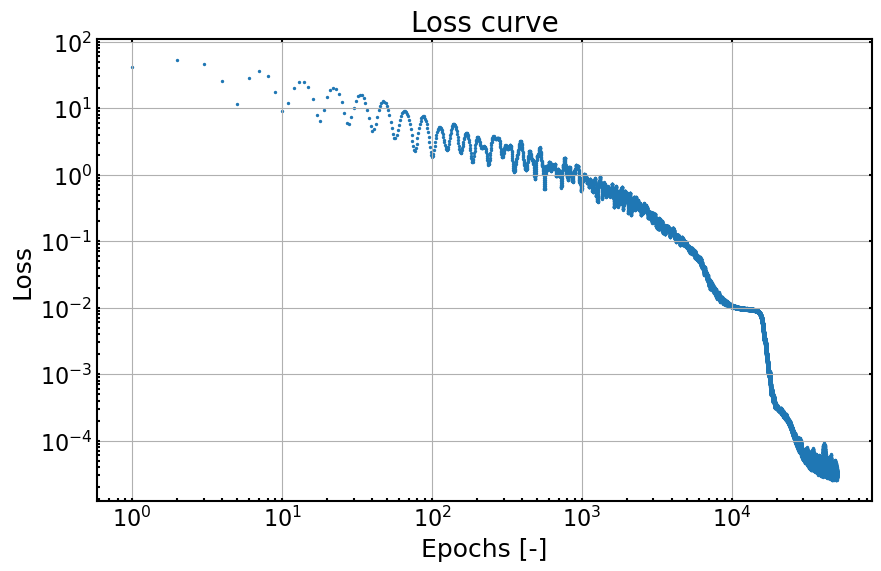

In [103]:
#loss = model.history.history["loss"]
fig, ax = plt.subplots(1, 1, figsize = (10, 6))

ax.scatter(np.arange(0, len(loss)), loss, s = 2)
ax.set_yscale("log")
ax.set_xscale("log")

ax.set_title("Loss curve", fontsize = 20)
ax.set_xlabel("Epochs [-]", fontsize = 18)
ax.set_ylabel("Loss", fontsize = 18)

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(1.5)
ax.tick_params(labelsize=16)
ax.tick_params(axis="both",direction="in",which="both", length=2, width = 1.5)
ax.tick_params(bottom=True, top=True, left=True, right=True)
ax.grid()

7/7 [==============================] - 0s 1ms/step


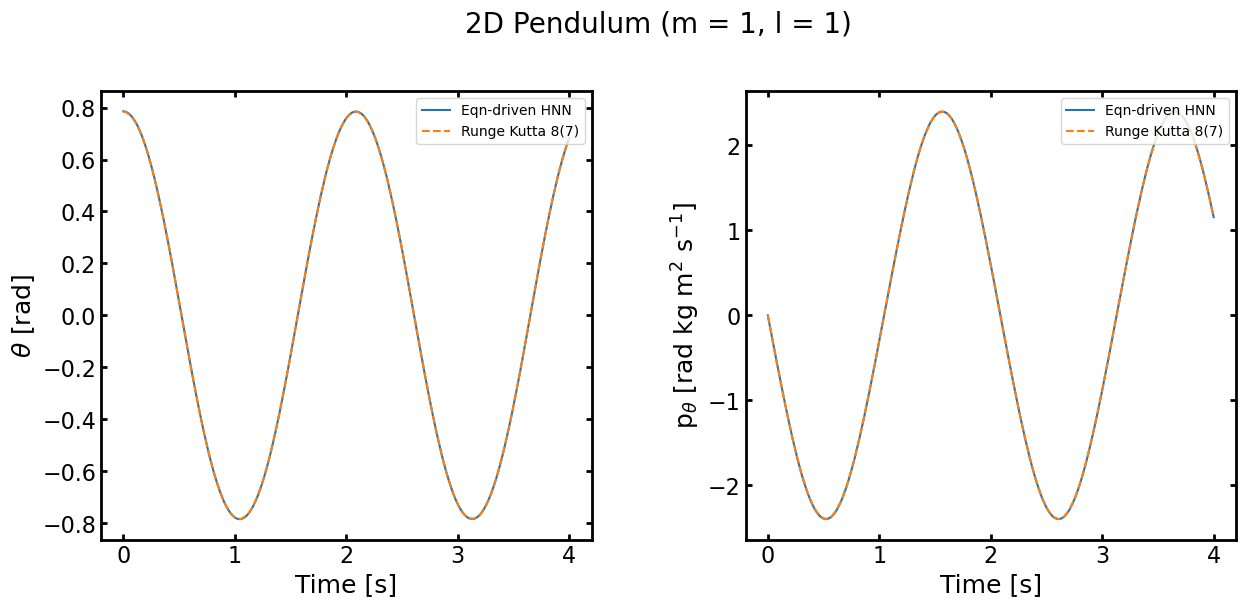

In [101]:
# def parametric_equation(times, states, initial_state): 
        
#     f = 1 - np.exp(-times)
#     result = np.repeat(np.array([initial_state]), len(states), axis=0) + f * states

#     return result
# states = parametric_equation(predict_time, regr.predict(predict_time), y0)

predict_time = np.linspace(t0, tfinal, N).reshape(-1, 1)
states = model.parametric_predict(predict_time) 

fig, axes = plt.subplots(1, 2, figsize = (14, 7))
fig.tight_layout(pad=8)
fig.suptitle(f"2D Pendulum (m = {m}, l = {l})", y = 0.95, fontsize = 20)
axes[0].plot(predict_time[:,0], states[:,0], label = "Eqn-driven HNN")
axes[0].plot(bench.states['canonical'][:,0], bench.states['canonical'][:,1], label = "Runge Kutta 8(7)", linestyle = '--')
axes[0].legend(loc = 'upper right')
axes[0].set_xlabel("Time [s]", fontsize = 18)
axes[0].set_ylabel(r"$\theta$ [rad]", fontsize = 18)

axes[1].plot(predict_time[:,0], states[:,1], label = "Eqn-driven HNN")
axes[1].plot(bench.states['canonical'][:,0], bench.states['canonical'][:,2], label = "Runge Kutta 8(7)", linestyle = '--')
axes[1].legend(loc = 'upper right')
axes[1].set_xlabel("Time [s]", fontsize = 18)
axes[1].set_ylabel(r"p$_{\theta}$ [rad kg m$^2$ s$^{-1}$]", fontsize = 18)

for ax in axes:
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(2)
    ax.tick_params(labelsize=16)
    ax.tick_params(axis="both",direction="in",which="both", length=4, width = 2)
    ax.tick_params(bottom=True, top=True, left=True, right=True)

In [ ]:
# This is a temporary method for saving
import os 

def save_model_weights(model, path, override = False):    
    
    if os.path.exists(path + ".index"): 
        if override: 
            print(f"I will overwrite: {path}")
        else: 
            raise ValueError("Path already exists")
            
    model.save_weights(path)

    
save_model_weights(model, "hnn_models/pendulum/model5.tf") 

In [45]:
def parametric_equation(self, 
                        times, 
                        states, 
                        initial_state): 
    
    # If predicting, with numpy times input, convert times to tensor
    tensor = tf.is_tensor(times)
    if not tensor: 
        tf.convert_to_tensor(times) 
    
    # Perform Parametric equation
    f = 1 - tf.math.exp(-times)
    result = initial_state + f * states
    
    # Return tensor if training and array if predicting
    if tensor: 
        return result
    else: 
        return result.numpy()




states= tf.convert_to_tensor([[1, 2], [5, 6]], dtype=tf.float32)

print(states)
print(type(states))

if not tf.is_tensor(states):
    print("tensor")
print(states.numpy())

tf.Tensor(
[[1. 2.]
 [5. 6.]], shape=(2, 2), dtype=float32)
<class 'tensorflow.python.framework.ops.EagerTensor'>
[[1. 2.]
 [5. 6.]]


In [40]:
mse = tf.keras.losses.MeanSquaredError()
a = tf.convert_to_tensor([[1, 2], [3, 4], [5, 6], [7, 8]], dtype=tf.float32 )
b = tf.convert_to_tensor([[8, 6], [2, 8], [5, 9], [2, 7]], dtype=tf.float32 )
loss = mse(a, b).numpy()
print(type(loss))
print(loss)

def custom_mse(y_true, y_pred):  
        
    
    difference = y_true - y_pred 
    difference_squared = difference**2
    loss = tf.math.reduce_mean(tf.math.reduce_sum(difference_squared, axis = 1))
        
    return loss

loss2 = custom_mse(a, b)
print(loss2)

<class 'numpy.float32'>
14.625
tf.Tensor(29.25, shape=(), dtype=float32)


In [15]:
# This will be the new saving method, hopefully...
regr.model_.save("hnn_models/pendulum/model2")

TypeError: tf.float32 has type DType, but expected one of: int, long, bool

In [687]:
tens = tf.convert_to_tensor([[1, 2, 3, 4], [5, 6, 7, 8]], dtype=tf.float32 )

def hamilton_equation(tens, m, l): 
            
        deriv = tf.zeros(tens.shape)
        q_tens = tens[:,:2]
        p_tens = tens[:,2:]
        
        q_deriv = tf.multiply(p_tens, 1./(m*l*l))
        p_deriv = tf.multiply(p_tens, -9.81 * m *l) 
        
        deriv = tf.concat([q_deriv, p_deriv], axis = 1)
        
        return deriv 
    
hamilton_equation(tens, 10, 10)

<tf.Tensor: shape=(2, 4), dtype=float32, numpy=
array([[ 3.000e-03,  4.000e-03, -2.943e+03, -3.924e+03],
       [ 7.000e-03,  8.000e-03, -6.867e+03, -7.848e+03]], dtype=float32)>

In [234]:
states = tf.convert_to_tensor([[10, 100], [12, 102], [14, 140]], dtype=tf.float32 )
state_0 = tf.convert_to_tensor([1, 2], dtype=tf.float32 )

times = tf.convert_to_tensor([[1.3],[3.4],[4.3]], dtype=tf.float32) 

def parametric_equation(times, states, state_0): 
        
    f = 1 - np.exp(-times)
    print(f) 
    print(states)
    print(f*states)
    print("state_0 = ", state_0)
    result = state_0 + f*states
    print(result)
    return result

parametric_equation(times, states, state_0)

a = tf.convert_to_tensor([[1, 1], [2, 2], [3,3]], dtype=tf.float32)
b = tf.convert_to_tensor([10, 20], dtype=tf.float32)
print(a)
print(b)
print(b + a)

[[0.7274682 ]
 [0.96662676]
 [0.9864314 ]]
tf.Tensor(
[[ 10. 100.]
 [ 12. 102.]
 [ 14. 140.]], shape=(3, 2), dtype=float32)
tf.Tensor(
[[  7.274682   72.74682  ]
 [ 11.599522   98.59593  ]
 [ 13.8100395 138.1004   ]], shape=(3, 2), dtype=float32)
state_0 =  tf.Tensor([1. 2.], shape=(2,), dtype=float32)
tf.Tensor(
[[  8.274682   74.74682  ]
 [ 12.599522  100.59593  ]
 [ 14.8100395 140.1004   ]], shape=(3, 2), dtype=float32)
tf.Tensor(
[[1. 1.]
 [2. 2.]
 [3. 3.]], shape=(3, 2), dtype=float32)
tf.Tensor([10. 20.], shape=(2,), dtype=float32)
tf.Tensor(
[[11. 21.]
 [12. 22.]
 [13. 23.]], shape=(3, 2), dtype=float32)


In [146]:
import tensorflow as tf

N = 10 
def my_function(x):
    a = x**2
    b = x**3
    c = x**4
    return tf.concat([a, b, c], axis = 1)

x = tf.reshape(tf.range(N, dtype=tf.float32), (-1,1))

with tf.GradientTape(persistent=True) as tape:
    tape.watch(x)
    a = my_function(x)

deriv = tape.jacobian(a, x)

# Reshaping the Jacobian using tensor magic...
idx = tf.reshape(tf.stack(tf.meshgrid(tf.range(a.shape[0]), tf.range(a.shape[1]), indexing='ij'), axis=-1), [-1, 2])
idx = tf.expand_dims(tf.concat([idx, tf.expand_dims(idx[:, 0], axis=-1)], axis=-1), axis=1)
deriv = tf.gather_nd(deriv, idx)
deriv = tf.reshape(deriv, a.shape)

print(x)
print(a)
print(deriv)

tf.Tensor(
[[0.]
 [1.]
 [2.]
 [3.]
 [4.]
 [5.]
 [6.]
 [7.]
 [8.]
 [9.]], shape=(10, 1), dtype=float32)
tf.Tensor(
[[0.000e+00 0.000e+00 0.000e+00]
 [1.000e+00 1.000e+00 1.000e+00]
 [4.000e+00 8.000e+00 1.600e+01]
 [9.000e+00 2.700e+01 8.100e+01]
 [1.600e+01 6.400e+01 2.560e+02]
 [2.500e+01 1.250e+02 6.250e+02]
 [3.600e+01 2.160e+02 1.296e+03]
 [4.900e+01 3.430e+02 2.401e+03]
 [6.400e+01 5.120e+02 4.096e+03]
 [8.100e+01 7.290e+02 6.561e+03]], shape=(10, 3), dtype=float32)
tf.Tensor(
[[0.000e+00 0.000e+00 0.000e+00]
 [2.000e+00 3.000e+00 4.000e+00]
 [4.000e+00 1.200e+01 3.200e+01]
 [6.000e+00 2.700e+01 1.080e+02]
 [8.000e+00 4.800e+01 2.560e+02]
 [1.000e+01 7.500e+01 5.000e+02]
 [1.200e+01 1.080e+02 8.640e+02]
 [1.400e+01 1.470e+02 1.372e+03]
 [1.600e+01 1.920e+02 2.048e+03]
 [1.800e+01 2.430e+02 2.916e+03]], shape=(10, 3), dtype=float32)


In [129]:
import tensorflow as tf
M = 10
N = 2

old = tf.ones((M, N, M, 1))  # Example input tensor
idx = tf.stack([tf.range(M)[:, tf.newaxis], tf.range(N)], axis=-1)
new = tf.gather_nd(old, tf.concat([idx, idx[:, :1, tf.newaxis]], axis=-1))


InvalidArgumentError: {{function_node __wrapped__Pack_N_2_device_/job:localhost/replica:0/task:0/device:CPU:0}} Shapes of all inputs must match: values[0].shape = [10,1] != values[1].shape = [2] [Op:Pack] name: stack

In [235]:
import tensorflow as tf

M = 14
N = 5

old = tf.ones((M, N, M, 1))  # Example input tensor

# Create index tensor with shape (M*N, 2)
idx = tf.reshape(tf.stack(tf.meshgrid(tf.range(M), tf.range(N), indexing='ij'), axis=-1), [-1, 2])

# Modify index tensor to have shape (M*N, 1, 1, 3)
idx = tf.expand_dims(tf.concat([idx, tf.expand_dims(idx[:, 0], axis=-1)], axis=-1), axis=1)

# Use gather_nd to extract elements from old tensor
new = tf.gather_nd(old, idx)

# Reshape the resulting tensor to shape (M, N)
new = tf.reshape(new, [M, N])


In [243]:
from tensorflow.keras.losses import mean_absolute_error

y_true = tf.convert_to_tensor([[100, 100], 
                               [100, 100], 
                               [100, 100]], dtype=tf.float32 )

y_pred = tf.convert_to_tensor([[1, 2], 
                               [3, 4], 
                               [5, 6]], dtype=tf.float32 )



def MSE_custom_loss(y_true, y_pred): 
    print(tf.math.reduce_mean(y_true - y_pred))
    print(mean_absolute_error(y_true, y_pred))
    return None

a = MSE_custom_loss(y_true, y_pred)

tf.Tensor(96.5, shape=(), dtype=float32)
tf.Tensor([98.5 96.5 94.5], shape=(3,), dtype=float32)


In [53]:
import tensorflow as tf

def perturbPoints(times): 
    
    # Extract informatio
    dt = times[1] - times[0]
    t0 = times[0]
    tfinal = times[-1]
    
    # Create noise
    noise = tf.random.normal(times.shape, mean = 0, stddev = 0.4*dt)
    
    # Perturb times
    new_times = times + noise 
    
    # Make sure time is not outside [t0, tf]: set to t0 or tf if violated
    new_times = tf.where(tf.less(new_times, t0), t0, new_times)
    new_times = tf.where(tf.greater(new_times, tfinal), tfinal, new_times)
    
    return new_times

times = tf.reshape(tf.convert_to_tensor([0, 1, 2, 3, 4, 5, 6], dtype=tf.float32 ), (-1, 1))
perturbPoints(times)

tf.Tensor(
[[0.]
 [1.]
 [2.]
 [3.]
 [4.]
 [5.]
 [6.]], shape=(7, 1), dtype=float32)
tf.Tensor(
[[-0.5238063]
 [ 0.8654609]
 [ 1.8617184]
 [ 2.9132996]
 [ 4.2779264]
 [ 4.92798  ]
 [ 5.7338076]], shape=(7, 1), dtype=float32)
tf.Tensor(
[[0.       ]
 [0.8654609]
 [1.8617184]
 [2.9132996]
 [4.2779264]
 [4.92798  ]
 [5.7338076]], shape=(7, 1), dtype=float32)
